<a href="https://colab.research.google.com/github/Ladvien/deep_arcane/blob/main/generate_symbol_object_detection_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Upgrade Pillow
!python3 -m pip install --upgrade --user pip
!python3 -m pip install --upgrade --user Pillow

In [2]:
import numpy as np

# Image Visualization.
from PIL import Image, ImageEnhance, ImageOps, ImageStat
import textwrap, os

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import ImageGrid

from glob2 import glob
from random import randint, uniform as random_float

In [3]:
# Setup data directory.
!mkdir -p "/content/data/inputs/clean_bold_magic_symbols/"
!mkdir "/content/output/"

# You will need to upload your data file manually Google Drive.
!tar -xf  '/content/drive/MyDrive/datasets/clean_bold_magic_symbols.tar.gz' -C '/content/data/inputs/clean_bold_magic_symbols/'

# Uncomment to include icons for extra training data.
# !mkdir -p "/content/data/inputs/icons/"
# !tar -xf  '/content/drive/MyDrive/datasets/icons_light.tar.gz' -C '/content/data/inputs/icons/'

!mkdir -p "/content/data/random_images/"
!tar -xf  '/content/drive/MyDrive/datasets/random_images.tar.gz' -C '/content/data/'

mkdir: cannot create directory ‘/content/output/’: File exists


## Help Functions
`display_images` function was written by Kees C. Bakker.

https://keestalkstech.com/2020/05/plotting-a-grid-of-pil-images-in-jupyter/


In [4]:
def display_images(
    images: [Image], 
    columns=5, width=20, height=8, max_images=50, 
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)

        if hasattr(image, 'filename'):
            title=image.filename
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)
            plt.title(title, fontsize=label_font_size); 

## Parameters

In [5]:
# Paths
INPUT_IMAGE_DIR = "/content/data/inputs/"
RANDOM_IMAGES_DIR = "/content/data/random_images/"

# Max rotation.
DEGREES = 180
MIN_SIZE_ADJ_PERC = 0.09
MAX_SIZE_ADJ_PERC = 0.15

BACKGROUND_BRIGHTNESS_THRESHOLD = 105

## Get Image Paths

In [6]:
background_image_paths = glob(RANDOM_IMAGES_DIR + "*/*.jpg", recursive=True) +\
                         glob(RANDOM_IMAGES_DIR + "*/*.png", recursive=True)

symbol_image_paths = glob(INPUT_IMAGE_DIR + "*/*.png", recursive=True)

## Plan

1. Load target symbols and background images
2. Randomly transform symbol(s)
   * Resize
   * Warp
   * Add Noise
3. Apply the symbol(s) to a random background image.
4. Create a mask. Generate a black image the same size as the background. Apply the symbol(s) in the exact same position, but transform the symbol into a bold color.
5. Save background image with symbol(s) and mask.


## Preview Background Images

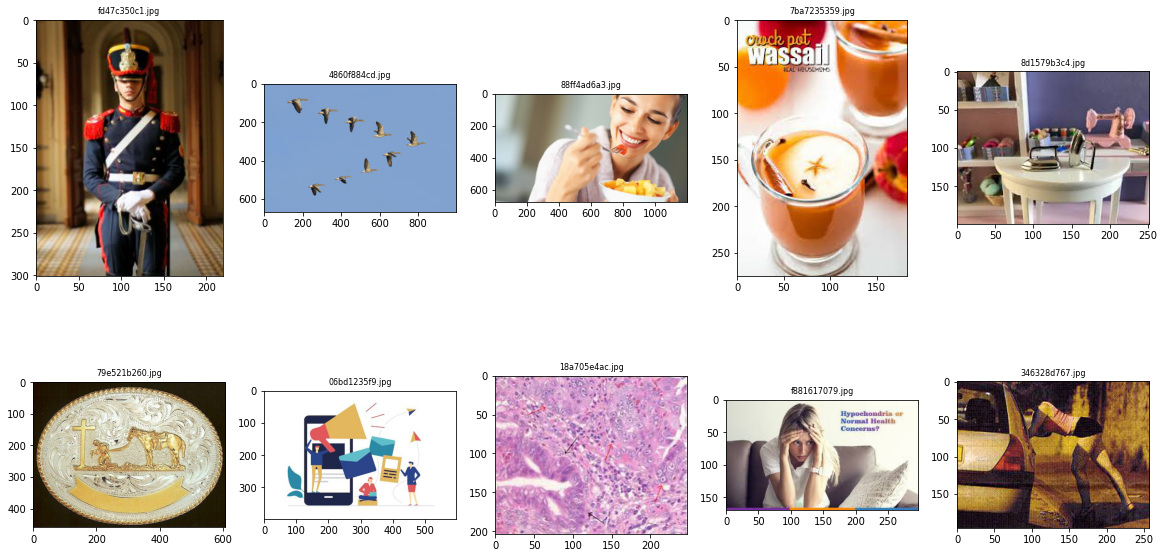

In [7]:
back_imgs = [Image.open(background_image_paths[randint(0, len(background_image_paths) - 1)]) for i in range(0, 10)]
display_images(back_imgs)

## Preview Symbols

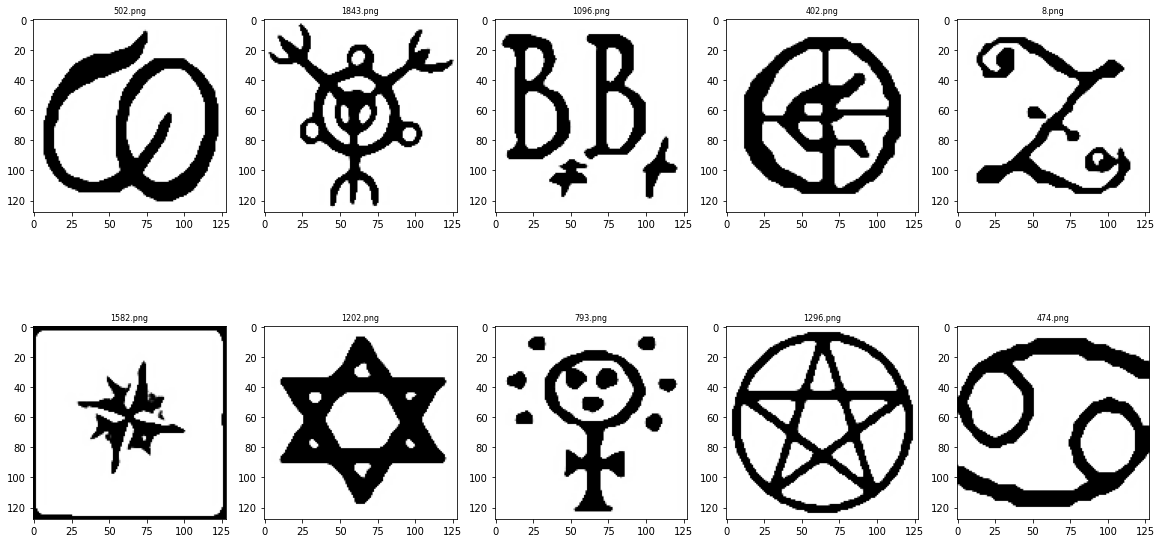

In [8]:
sym_imgs = [Image.open(symbol_image_paths[randint(0, len(symbol_image_paths) - 1)]) for i in range(0, 10)]
display_images(sym_imgs)

Skipping background, too dark.
Skipping background, too dark.
Skipping background, too dark.
Skipping background, too dark.
Skipping background, too dark.
Skipping background, too dark.
Skipping background, too dark.
Skipping background, too dark.
Skipping background, too dark.
Skipping background, too dark.
Showing 50 images of 80:


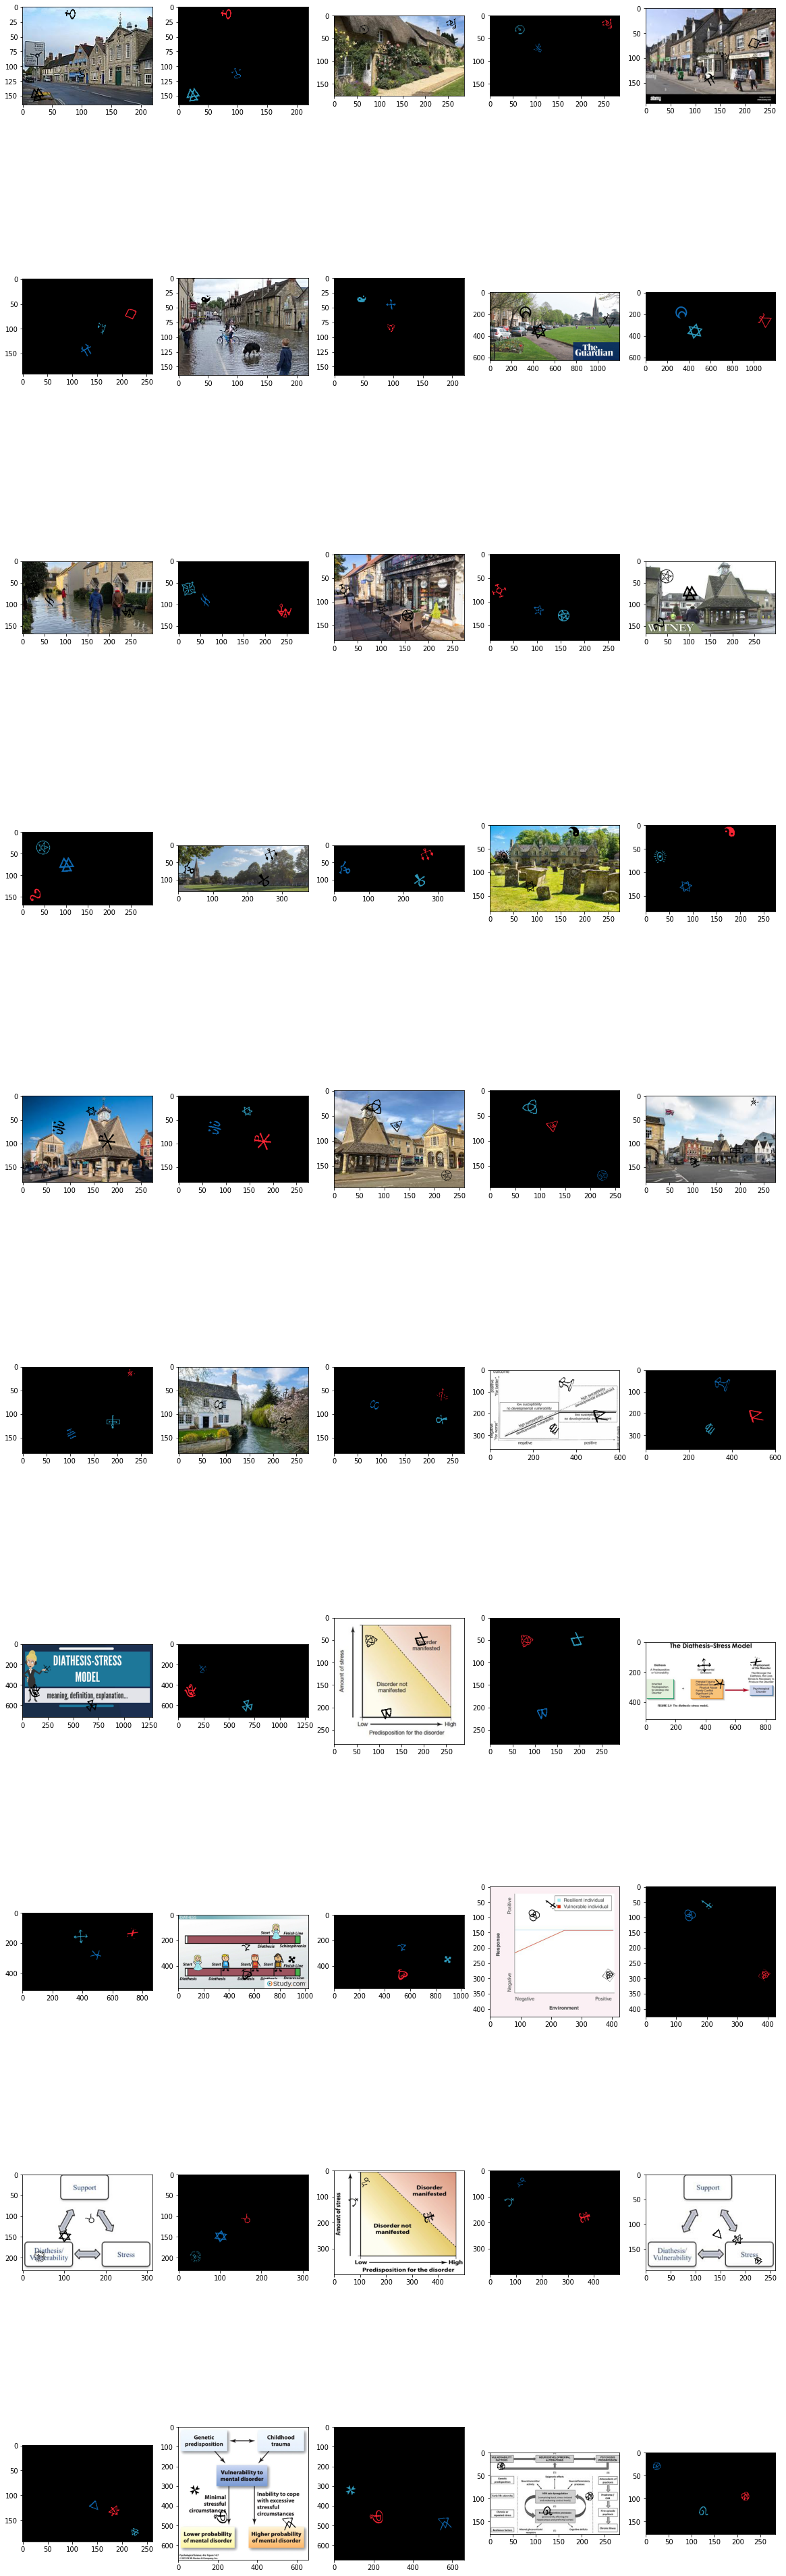

In [10]:
class EmbeddedSizeExceedsBackgroundSize(Exception):
    def __str__(self) -> str:
        return "The embedded image is larger than the embedded image."


class Coordinates:
    def __init__(self, x: int, y: int, width: int, height: int):
        self.x1 = x
        self.y1 = y
        self.x2 = x + width
        self.y2 = y + height

    def data(self):
        return {
            "x1": self.x1,
            "y1": self.y1,
            "x2": self.x2,
            "y2": self.y2
        }

    def __str__(self):
        return str(self.data())

class EmbeddedImageAttributes:
    def __init__(
        self,
        background_img: Image,
        embedded_img: Image,
        min_size_adjustment: float,
        max_size_adjustment: float,
        max_rotation: int,
    ):

        self.embedded_img = embedded_img.copy()
        self.background_img = background_img.copy()

        adj = ImageAdjustments()

        self.embedded_img = adj.convert_to_rgba(self.embedded_img)
        self.rotation = self._get_random_degrees(max_rotation)
        self.embedded_img = adj.rotate(self.embedded_img, self.rotation)
        self.size = self._get_random_size(min_size_adjustment, max_size_adjustment)
        self.x1, self.y1 = self._get_random_embedded_coords()

        self.width = self.size
        self.height = self.size

        self.coordinates = Coordinates(self.x1, self.y1, self.width, self.height)

    def _get_random_size(self, min_value: float, max_value: float) -> int:
        max_back_dim = max(self.background_img.size)
        return int(random_float(min_value, max_value) * max_back_dim)

    def _get_random_embedded_coords(self) -> Image:
        # Get minimums. Pillow is (width, height)
        max_x = self.background_img.size[0] - self.size
        max_y = self.background_img.size[1] - self.size

        if max_x < 0 or max_y < 0:
            raise EmbeddedSizeExceedsBackgroundSize

        return (randint(0, max_x), randint(0, max_y))

    def _get_random_degrees(self, max_rotation: int):
        return randint(-1 * max_rotation, max_rotation)

    def data(self):
        return {
            "size": self.size,
            "coordinates": self.coordinates,
            "degrees_to_rotate": self.rotation,
        }

    def __str__(self):
        return str(self.data())


class ImageAdjustments:
    def __init__(self,):
        pass

    def convert_to_bw(self, img: Image) -> Image:
        return img.convert("1")

    def convert_to_rgb(self, img: Image) -> Image:
        return img.convert("RGB")

    def convert_to_rgba(self, img: Image) -> Image:
        return img.convert("RGBA")

    def resize_img_by_perc(
        self, img: Image, width_perc: float, height_perc: float
    ) -> Image:
        orig_width, orig_height = img.size

        new_width = int(orig_width * width_perc)
        new_height = int(orig_height * height_perc)

        img = img.resize((new_width, new_height))

        return img

    def resize_by_pixels(self, img: Image, width: int, height: int) -> Image:
        return img.resize((width, height))

    def color_swap(
        self, img: Image, target_color: tuple, new_color: tuple, threshold: int = 10
    ) -> Image:
        new_img = []
        for pixel in img.getdata():
            if self.is_pixel_color_in_range(pixel, target_color, threshold):
                new_img.append(new_color)
            else:
                new_img.append(pixel)

        img.putdata(new_img)
        return img

    def is_color_value_in_range(
        self, value: int, target_value: int, threshold: int
    ) -> bool:
        return value in list(range(target_value - threshold, target_value + threshold))

    def is_pixel_color_in_range(
        self, pixel: tuple, target_color: tuple, threshold: int
    ) -> bool:
        return all(
            self.is_color_value_in_range(value, target_color[i], threshold)
            for i, value in enumerate(pixel)
        )

    def paste_image(
        self, main_img: Image, paste_img: Image, coords: Coordinates
    ) -> Image:
        main_img_mask = Image.new("RGBA", main_img.size, 0)
        main_img_mask.paste(paste_img, (coords.x1, coords.y1))

        target_color = (255, 255, 255, 255)  # Opaque white.
        new_color = (255, 255, 255, 0)  # Transparent black.
        main_img_mask = self.color_swap(
            main_img_mask, target_color, new_color, threshold=20
        )

        main_img.alpha_composite(main_img_mask)

        return main_img

    def make_white_transparent(self, img: Image, threshold: int) -> Image:
        new_color = (255, 255, 255, 0)
        target_color = (255, 255, 255, 255)
        return self.color_swap(img, target_color, new_color, threshold=threshold)

    def make_two_colors(self, img: Image, primary: tuple, secondary: tuple) -> Image:
        new_img = []
        for pixel in img.getdata():
            if pixel in [primary, secondary]:
                new_img.append(pixel)
            else:
                new_img.append(primary)

        img.putdata(new_img)
        return img

    def rotate(self, img: Image, degrees: int) -> Image:
        return img.rotate(degrees, fillcolor=(255, 255, 255, 255), expand=True)


class MaskTrainingDataComposer:
    def __init__(self):
        self.transforms = ImageAdjustments()

    def get_image_with_embedded_image(
        self,
        main_img: Image,
        embedded_img: Image,
        change_attrs: EmbeddedImageAttributes,
    ) -> Image:

        # Load random images.
        embedded_img = self.transforms.convert_to_rgba(
            self.transforms.convert_to_bw(embedded_img)
        )

        # Rotate
        embedded_img = self.transforms.rotate(embedded_img, change_attrs.rotation)

        # Resize image.
        embedded_img = self.transforms.resize_by_pixels(
            embedded_img, change_attrs.size, change_attrs.size
        )

        # Add alpha channel.
        embedded_img = self.transforms.convert_to_rgba(
            self.transforms.convert_to_bw(embedded_img)
        )
        
        # Swap white transparent.
        embedded_img = self.transforms.make_white_transparent(embedded_img, 60)

        # Position.
        return self.transforms.paste_image(
            self.transforms.convert_to_rgba(main_img),
            embedded_img,
            change_attrs.coordinates,
        )

    def get_color_mask(
        self,
        main_img: Image,
        embedded_img: Image,
        change_attrs: EmbeddedImageAttributes,
        color: tuple,
    ) -> Image:

        img = Image.new("RGBA", main_img.size, (0, 0, 0, 0))

        # Rotate
        embedded_img = self.transforms.rotate(
            self.transforms.convert_to_rgba(
                self.transforms.convert_to_bw(embedded_img)
            ),
            change_attrs.rotation,
        )

        # Resize image.
        embedded_img = self.transforms.resize_by_pixels(
            embedded_img, change_attrs.size, change_attrs.size
        )

        # Add alpha channel.
        embedded_img = self.transforms.convert_to_rgba(embedded_img)

        # Swap white transparent.
        embedded_img = self.transforms.make_white_transparent(embedded_img, 150)

        # Set color.
        black = (0, 0, 0, 255)
        mask_color = color
        embedded_img = self.transforms.color_swap(embedded_img, black, mask_color, 127)
        embedded_img = self.transforms.make_two_colors(embedded_img, black, mask_color)

        # Position.
        return self.transforms.paste_image(
            self.transforms.convert_to_rgba(img), embedded_img, change_attrs.coordinates
        )


class OccludedCheck:
    def __init__(self, rects: list, rect2: Coordinates):
        self.rects = rects
        self.rect2 = rect2

    def check_occlusion(self) -> bool:
        return any((
                    rect1.x1 < self.rect2.x2
                and rect1.x2 > self.rect2.x1
                and rect1.y1 < self.rect2.y2
                and rect1.y2 > self.rect2.y1
            ) for rect1 in self.rects)
        

class ImageInfo:

    def __init__(self, img: Image):
        self.img = img.copy()
        self.stats = ImageStat.Stat(self.img.convert("L"))

    def brightness(self) -> int:
        return self.stats.mean[0]


class ExtendedImage(Image):

    def __init__(self) -> None:
        super().__init__()


    def random_crop(self):
        self.



class MaskTrainingDataGenerator:
    def __init__(
        self,
        paths_to_images: list,
        paths_to_embedded_imgs,
        embedded_imgs_per_img=3,
        attempts_to_avoid_occlusion=50,
    ):
        self.paths_to_images = paths_to_images
        self.paths_to_embedded_imgs = paths_to_embedded_imgs
        self.embedded_imgs_per_img = embedded_imgs_per_img
        self.attempts_to_avoid_occlusion = attempts_to_avoid_occlusion
        self.colors = [
            (randint(0, 255), randint(0, 255), randint(0, 255), 255)
            for _ in range(embedded_imgs_per_img)
        ]

    def check_all_embedded_images_for_occlusion(self, img: Image, embedded_img: Image, embedded_img_coords: list):
        for k in range(self.attempts_to_avoid_occlusion):
            attrs = EmbeddedImageAttributes(
                img,
                embedded_img,
                MIN_SIZE_ADJ_PERC,
                MAX_SIZE_ADJ_PERC,
                DEGREES,
            )
            oc = OccludedCheck(embedded_img_coords, attrs.coordinates)
            if not oc.check_occlusion():
                break

        return attrs

    def generate(self, number_to_generate: int):
        imgs = []
        masks = []

        for i in range(number_to_generate):

            back_img = Image.open(self.paths_to_images[i])
            if ImageInfo(back_img).brightness() < BACKGROUND_BRIGHTNESS_THRESHOLD:
                print("Skipping background, too dark.")
                continue
            
            masks_accumulator = []
            embedded_img_coords = []

            for j in range(self.embedded_imgs_per_img):
                try:

                    sym_img = Image.open(
                        self.paths_to_embedded_imgs[
                            randint(0, len(self.paths_to_embedded_imgs) -  1)
                        ]
                    )

                    attrs = self.check_all_embedded_images_for_occlusion(back_img, sym_img, embedded_img_coords)
                    embedded_img_coords.append(attrs.coordinates)

                    composer = MaskTrainingDataComposer()
                    back_img = composer.get_image_with_embedded_image(
                        back_img, sym_img, attrs
                    )
                    masks_accumulator.append(
                        composer.get_color_mask(
                            back_img, sym_img, attrs, self.colors[j]
                        )
                    )

                except EmbeddedSizeExceedsBackgroundSize:
                    print("Skipping")

            base_mask = Image.new("RGBA", back_img.size, (0, 0, 0, 255))
            for mask in masks_accumulator:
                base_mask.alpha_composite(mask)

            imgs.append(back_img)
            masks.append(base_mask)

        return (imgs, masks)


# 4. BONUS: change symbol color to blend.

generator = MaskTrainingDataGenerator(background_image_paths, symbol_image_paths, 3)
imgs, masks = generator.generate(50)

collated_imgs = []
for i in range(len(imgs)):
    collated_imgs.append(imgs[i])
    collated_imgs.append(masks[i])

display_images(collated_imgs)
